In [25]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import seaborn as sns


In [4]:
h5_filepath = r"SpikeData_300.h5"

with h5py.File(h5_filepath, 'r') as df:
    for key in df.keys():
       print(key)
    start = df["spikes/start"][:]
    middle = df["spikes/start"][:]
    end = df["spikes/start"][:]
    patterns = df["spikes/patterns"][:]
    decoded_patterns = [p.decode('utf-8') for p in patterns]
    print(patterns)
    print(df["t_array"][:])
    
    print(df["X"][()])
    print(df["dt"][()])
    print(df["total_time"][()])

X
dt
spikes
t_array
total_time
[b'Regular' b'Regular' b'Regular' b'Semiregular' b'Regular' b'Regular'
 b'Irregular' b'Regular' b'Semiregular' b'Regular' b'Regular' b'Irregular'
 b'Irregular' b'Regular' b'Semiregular' b'Semiregular' b'Regular'
 b'Irregular' b'Regular' b'Regular' b'Regular' b'Regular' b'Regular'
 b'Regular' b'Irregular' b'Regular' b'Regular' b'Regular' b'Regular'
 b'Regular' b'Semiregular' b'Irregular' b'Semiregular' b'Regular'
 b'Irregular' b'Semiregular' b'Irregular' b'Regular' b'Regular' b'Regular'
 b'Regular' b'Regular' b'Irregular' b'Regular' b'Regular' b'Regular'
 b'Semiregular' b'Regular' b'Regular' b'Regular' b'Regular' b'Regular'
 b'Regular' b'Semiregular' b'Regular' b'Regular' b'Irregular'
 b'Semiregular' b'Regular' b'Regular' b'Regular' b'Semiregular' b'Regular'
 b'Regular' b'Regular' b'Semiregular' b'Regular' b'Regular' b'Semiregular'
 b'Regular' b'Regular' b'Regular' b'Semiregular' b'Regular' b'Regular'
 b'Semiregular' b'Regular' b'Irregular' b'Regular' b'Re

In [7]:
axon_palette = {
    "regular": "red",
    "irregular": "green",
    "semiregular": "blue"
}

# for mat files
def classify_axon(i, regular=65, irregular=[65, 83]):
    if i < regular:
        return "regular"
    elif irregular[0] <= i < irregular[1]:
        return "irregular"
    else:
        return "semiregular"

0       regular
1       regular
2       regular
3       regular
4       regular
         ...   
4607    regular
4608    regular
4609    regular
4610    regular
4611    regular
Name: axon_type, Length: 4612, dtype: object


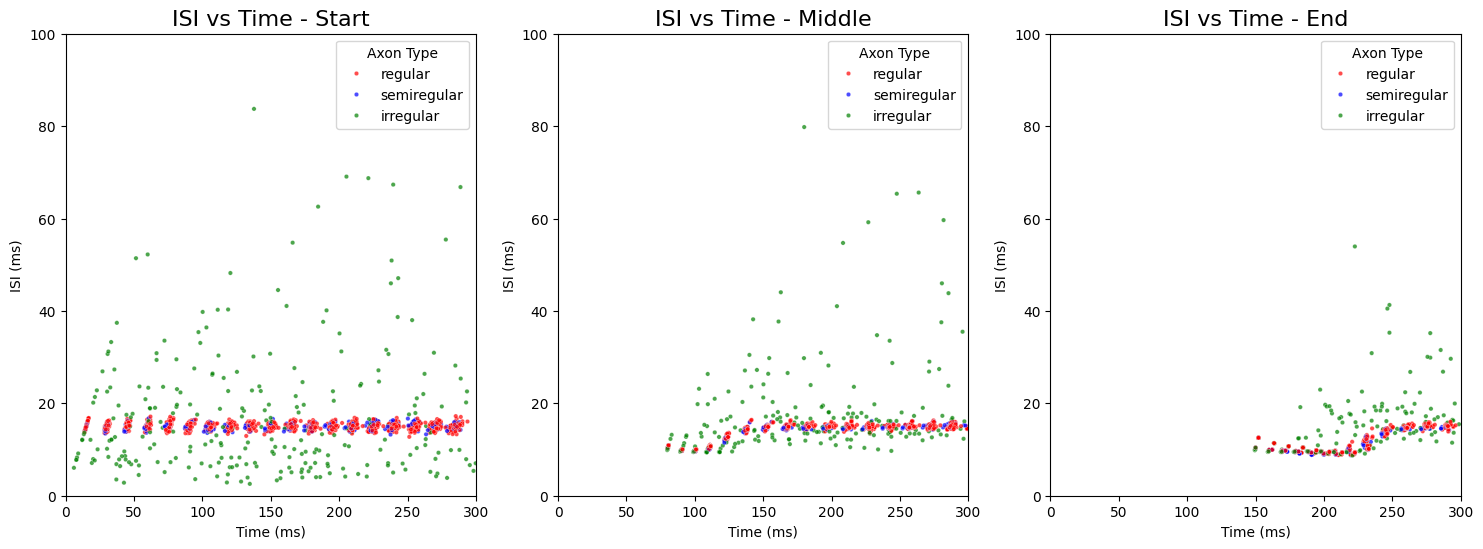

In [34]:
def classify_and_sort_hdf5(patterns, spike_data_raw):

    regular_spikes, irregular_spikes, semiregular_spikes = [], [], []
    regular_patterns, irregular_patterns, semiregular_patterns = [], [], []

    # classify axons 
    for i in range(len(patterns)):
        p = patterns[i]
        spikes = spike_data_raw[i]
        if p == "regular":
            regular_spikes.append(spikes)
            regular_patterns.append(p)
        elif p == "irregular":
            irregular_spikes.append(spikes)
            irregular_patterns.append(p)
        elif p == "semiregular":
            semiregular_spikes.append(spikes)
            semiregular_patterns.append(p)

    spikes_sorted = regular_spikes + irregular_spikes + semiregular_spikes
    patterns_sorted = regular_patterns + irregular_patterns + semiregular_patterns

    return spikes_sorted, patterns_sorted    

def prepare_isi_dataframe(spike_times_dict, pattern):
    data = []
    
    for axon, spikes in spike_times_dict.items():
        if len(spikes) > 1:
            ISI = np.diff(spikes)  # Вычисляем межспайковые интервалы
            times = spikes[1:]     # Временные метки
            axon_type = pattern[axon-1]
            
            # Добавляем данные в список
            for i in range(len(ISI)):
                data.append({
                    "axon": axon,
                    "axon_type": axon_type,
                    "ISI": ISI[i],
                    "time": times[i]
                })
                
    return pd.DataFrame(data)

def plot_h5_raster(h5_filepath):
    with h5py.File(h5_filepath, 'r') as df:
        raw_patterns = df["spikes/patterns"][:]
        patterns = [p.decode("utf-8").lower() for p in raw_patterns]
        
        spike_data_raw_start = df["spikes/start"][:]
        spike_data_start = [row[~np.isnan(row)] for row in spike_data_raw_start]
        #spikes_start, patterns_start = classify_and_sort_hdf5(patterns, spike_data_start)

        spike_data_raw_middle = df["spikes/middle"][:]
        spike_data_middle = [row[~np.isnan(row)] for row in spike_data_raw_middle]
        #spikes_middle, patterns_middle = classify_and_sort_hdf5(patterns, spike_data_middle)

        spike_data_raw_end = df["spikes/end"][:]
        spike_data_end = [row[~np.isnan(row)] for row in spike_data_raw_end]
        #spikes_end, patterns_end = classify_and_sort_hdf5(patterns, spike_data_end)
        start = {}
        middle = {}
        end = {}
        for i in range(len(spike_data_raw_start)): start[i+1] = spike_data_raw_start[i]
        for i in range(len(spike_data_raw_middle)): middle[i+1] = spike_data_raw_middle[i]
        for i in range(len(spike_data_raw_end)): end[i+1] = spike_data_raw_end[i]
        
        df_start = prepare_isi_dataframe(start, patterns)
        df_middle = prepare_isi_dataframe(middle, patterns)
        df_end = prepare_isi_dataframe(end, patterns)

        df_start["phase"] = "Start"
        df_middle["phase"] = "Middle"
        df_end["phase"] = "End"

        df_all = pd.concat([df_start, df_middle, df_end], ignore_index=True)
        print(df_all["axon_type"])
        # Определяем границы осей
        x_min, x_max = df_all["time"].min(), df_all["time"].max()
        y_min, y_max = df_all["ISI"].min(), df_all["ISI"].max()
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        i = 0
        for phase in df_all["phase"].unique():
            df_phase = df_all[df_all["phase"] == phase]
    
    
    
            # ISI vs Time
            sns.scatterplot(data=df_phase, x="time", y="ISI", hue="axon_type", palette=axon_palette, alpha=0.7, s=10,
                            ax=axes[i])
            axes[i].set_xlabel("Time (ms)")
            axes[i].set_ylabel("ISI (ms)")
            axes[i].set_title(f"ISI vs Time - {phase}", fontsize=16)
            axes[i].legend(title="Axon Type")
            axes[i].set_xlim(0, 300)
            axes[i].set_ylim(0, 100)
            i+=1
    
        #fig.suptitle(f"Преобладает: {title}", fontsize=18, fontweight="bold")
    
    
        #plt.show()
        
        
        
    

    

# Пример вызова
h5_path = "SpikeData_300.h5"
mat_path = r"SpikeData.mat"

plot_h5_raster(h5_path)
#plot_mat_raster(mat_path)